# Kaggle Competition All Pieces

## Prep

In [442]:
# General libraries.
import re
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.stats import itemfreq

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [443]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")

#align by listing ids
train_df = train_df.set_index('listing_id')
test_df = test_df.set_index('listing_id')


In [444]:
from sklearn.model_selection import train_test_split
def split_data_for_test_and_dev(train_df):
    y = train_df['interest_level']
    y2 = y.replace({'low':1,'medium':2,'high':3})
    X = train_df.drop('interest_level', 1)
    return train_test_split(X, y2, test_size=0.2, random_state=1)
    
X_train, X_dev, y_train, y_dev = split_data_for_test_and_dev(train_df)

In [445]:
def accuracy_report(name, X_train, y_train, X_dev, y_dev):

    #LR
    #lr = LogisticRegression()
    #lr.fit(X_train, y_train)

    print('===============================')
    #print(name)
    
    #print('LR Training Accuracy: %.2f%% \t Test Accuracy: %.2f%%' % (
    #    lr.score(X_train, y_train)*100,                                                         
    #    lr.score(X_dev, y_dev)*100))
 
    ##precision (% select relevent), recall (% relevant selected)
    #print ('LR dev: \n{}'.format(classification_report(y_dev, lr.predict(X_dev))))
    #print itemfreq(lr.predict(X_dev))
    
    #RFC
    rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1) #-1 means use all available cores
    rfc.fit(X_train, y_train)
    print('RF Training Accuracy: %.2f%% \t Test Accuracy: %.2f%%' % (
        rfc.score(X_train, y_train)*100,                                                         
        rfc.score(X_dev, y_dev)*100))

    print ('RFC dev: \n{}'.format(classification_report(y_dev, rfc.predict(X_dev))))
    print itemfreq(rfc.predict(X_dev))

    importances = rfc.feature_importances_
    features = X_train.columns

    sort_indices = np.argsort(importances)[::-1]
    sorted_features = []
    for i in sort_indices:
        sorted_features.append(features[i])

    print('\nfeatures')
    print(sorted_features)
    print importances[sort_indices]

## Text Features

In [446]:
from string import punctuation
from sklearn.ensemble import RandomForestClassifier

#using dif var in case user wants to keep original df.
def add_txt_features(orig):
    dat = orig
    dat.loc[:,'strlen'] = [len(x) for x in dat['description']] #can ignore warnings because making new column
    dat.loc[:,'numwords'] = [len(x.split()) for x in dat['description']]
    dat.loc[:,'numcaps'] = [sum(1 for c in x if c.upper()) for x in dat['description']]
    dat.loc[:,'numpunct'] = [sum(1 for c in x if c in punctuation) for x in dat['description']]
    dat.loc[:,'richness'] = [len(set(x)) / (len(x)+0.001) for x in dat['description']]
    return dat

X_train = add_txt_features(X_train)
X_dev =   add_txt_features(X_dev)
#X_train.head()

feature_list = ['strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)

X_train_limited = X_train[['richness']]
X_dev_limited = X_dev[['richness']]
accuracy_report('richness only', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 94.55% 	 Test Accuracy: 67.48%
RFC dev: 
             precision    recall  f1-score   support

          1       0.73      0.89      0.80      6797
          2       0.38      0.21      0.28      2334
          3       0.31      0.11      0.16       740

avg / total       0.62      0.67      0.63      9871

[[   1 8319]
 [   2 1301]
 [   3  251]]

features
['richness', 'numwords', 'strlen', 'numpunct', 'numcaps']
[ 0.25811872  0.19368907  0.18455923  0.18259532  0.18103766]
RF Training Accuracy: 81.17% 	 Test Accuracy: 60.46%
RFC dev: 
             precision    recall  f1-score   support

          1       0.71      0.79      0.75      6797
          2       0.28      0.21      0.24      2334
          3       0.14      0.10      0.11       740

avg / total       0.57      0.60      0.58      9871

[[   1 7573]
 [   2 1778]
 [   3  520]]

features
['richness']
[ 1.]


RFC does better job with recall, but given these signalls, is still too heavy in assigning to 1 (Low)

## Price Features

In [447]:
def add_price_features(orig):
    dat = orig
    dat.loc[:,'price_per_bed'] = dat['price'] / (dat['bedrooms']+0.00001)
    dat.loc[:,'price_per_bath'] = dat['price'] / (dat['bathrooms']+0.00001)
    dat.loc[:,'price_per_room'] = dat['price'] / (dat['bathrooms'] + dat['bedrooms'] +0.00001)
    return dat

X_train = add_price_features(X_train)
X_dev =   add_price_features(X_dev)
#X_train.head()

feature_list = ['price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 96.71% 	 Test Accuracy: 69.44%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.89      0.82      6797
          2       0.42      0.28      0.34      2334
          3       0.39      0.23      0.29       740

avg / total       0.66      0.69      0.67      9871

[[   1 7887]
 [   2 1558]
 [   3  426]]

features
['richness', 'numpunct', 'strlen', 'numcaps', 'numwords', u'price', 'price_per_bed', 'price_per_room', 'price_per_bath', u'bedrooms', u'bathrooms']
[ 0.13960248  0.12240701  0.12074139  0.11936845  0.11817951  0.09534795
  0.09354827  0.08985651  0.08216829  0.0110563   0.00772384]


## Let's take a look at the number of photos

In [448]:
def get_num_photos(orig):
    dat = orig
    dat.loc[:,'numphotos'] = [len(x) for x in dat['photos'].values]
    return dat

X_train = get_num_photos(X_train)
X_dev =   get_num_photos(X_dev)

X_train_ph = X_train[['numphotos']]
X_dev_ph = X_dev[['numphotos']]

X_train_limited = X_train[['numphotos']]
X_dev_limited = X_dev[['numphotos']]
accuracy_report('photos', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['numphotos', 'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)

X_train_limited = X_train[['numphotos','richness']]
X_dev_limited = X_dev[['numphotos', 'richness']]
accuracy_report('num photos+richness', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 69.62% 	 Test Accuracy: 68.86%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.00      0.00      0.00      2334
          3       0.00      0.00      0.00       740

avg / total       0.47      0.69      0.56      9871

[[   1 9871]]

features
['numphotos']
[ 1.]
RF Training Accuracy: 97.05% 	 Test Accuracy: 69.48%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.89      0.82      6797
          2       0.41      0.26      0.32      2334
          3       0.40      0.24      0.30       740

avg / total       0.65      0.69      0.66      9871

[[   1 7964]
 [   2 1470]
 [   3  437]]

features
['richness', 'numpunct', 'numcaps', 'strlen', 'numwords', 'price_per_room', 'price_per_bed', 'price_per_bath', 'numphotos', u'price', u'bedrooms', u'bathrooms']
[ 0.12238568  0.11194447  0.1091259   0.10682855  0.10618679  0.08829881
  0.088231

## Time Info

In [449]:
def add_time_features(orig):  #(x,"%Y-%m-%d %H:%M:%S")
    dat = orig
    dat.loc[:,"created2"] = dat['created'].astype("datetime64");
     
    dat.loc[:,'year']   = dat['created2'].dt.year
    dat.loc[:,'month']  = dat['created2'].dt.month
    dat.loc[:,'day']    = dat['created2'].dt.day
    dat.loc[:,'weekday']= dat['created2'].dt.dayofweek
    dat.loc[:,'hour']   = dat['created2'].dt.hour
    dat.loc[:,'minute'] = dat['created2'].dt.minute
    dat.loc[:,'second'] = dat['created2'].dt.second
    dat.loc[:,'hr_min'] = dat['created2'].dt.hour.multiply(100).add(dat['created2'].dt.minute)
    return dat

X_train = add_time_features(X_train)
X_dev =   add_time_features(X_dev)

time_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min']
X_train_limited = X_train[time_list]
X_dev_limited =     X_dev[time_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 98.65% 	 Test Accuracy: 64.04%
RFC dev: 
             precision    recall  f1-score   support

          1       0.70      0.88      0.78      6797
          2       0.30      0.15      0.20      2334
          3       0.12      0.04      0.06       740

avg / total       0.56      0.64      0.59      9871

[[   1 8481]
 [   2 1153]
 [   3  237]]

features
['second', 'hr_min', 'minute', 'day', 'weekday', 'hour', 'month', 'year']
[ 0.32934644  0.21604488  0.18972831  0.1175041   0.0605296   0.05638208
  0.03046458  0.        ]
RF Training Accuracy: 99.48% 	 Test Accuracy: 70.80%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.25      0.32      2334
          3       0.48      0.19      0.27       740

avg / total       0.66      0.71      0.67      9871

[[   1 8297]
 [   2 1287]
 [   3  287]]

features
['hr_min', u'price', 'price_per_room', 'price_per_bed', 'richness

In [450]:
#print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

## Add in num features

In [451]:
#todo add in cleaning

def get_num_features(orig):
    dat = orig
    dat.loc[:,'numfeatures'] = [len(x) for x in dat['features'].values]
    return dat

X_train = get_num_features(X_train)
X_dev =   get_num_features(X_dev)

X_train_limited = X_train[['numfeatures']]
X_dev_limited = X_dev[['numfeatures']]
accuracy_report('numfeatures', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('numfeatures+phtotos+text', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 69.63% 	 Test Accuracy: 68.85%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.00      0.00      0.00      2334
          3       0.00      0.00      0.00       740

avg / total       0.47      0.69      0.56      9871

[[   1 9870]
 [   3    1]]

features
['numfeatures']
[ 1.]
RF Training Accuracy: 99.48% 	 Test Accuracy: 70.86%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.25      0.32      2334
          3       0.47      0.19      0.27       740

avg / total       0.66      0.71      0.67      9871

[[   1 8258]
 [   2 1320]
 [   3  293]]

features
['hr_min', 'price_per_room', 'price_per_bed', u'price', 'price_per_bath', 'richness', 'numpunct', 'second', 'numcaps', 'strlen', 'numwords', 'minute', 'day', 'numfeatures', 'numphotos', 'hour', 'weekday', 'month', u'bedrooms', u'

In [452]:
#print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

## Compare addresses

In [453]:
def get_address_dif(orig):
    dat = orig
    street_addr_len = [len(sa) for sa in dat['street_address']]
    display_addr_len = [len(da) for da in dat['display_address']]
    dat.loc[:,'addr_dif'] = np.subtract(street_addr_len,display_addr_len)
    return dat

X_train = get_address_dif(X_train)
X_dev =   get_address_dif(X_dev)


X_train_limited = X_train[['addr_dif']]
X_dev_limited = X_dev[['addr_dif']]
accuracy_report('addrdiff', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 69.75% 	 Test Accuracy: 68.82%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      0.99      0.82      6797
          2       0.43      0.02      0.04      2334
          3       0.07      0.00      0.00       740

avg / total       0.58      0.69      0.57      9871

[[   1 9757]
 [   2  100]
 [   3   14]]

features
['addr_dif']
[ 1.]
RF Training Accuracy: 99.50% 	 Test Accuracy: 70.80%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.44      0.26      0.32      2334
          3       0.47      0.18      0.26       740

avg / total       0.66      0.71      0.67      9871

[[   1 8223]
 [   2 1361]
 [   3  287]]

features
['hr_min', u'price', 'price_per_bed', 'price_per_room', 'numpunct', 'richness', 'second', 'numcaps', 'price_per_bath', 'minute', 'numwords', 'strlen', 'day', 'numfeatures', 'numphotos', 'hour', 'weekday', 'addr_dif', 'm

## Adding in Neighborhoods

In [454]:
from sklearn.cluster import KMeans
np.random.seed(0)

#from scipy import stats
#remvoe outliers
def remove_outliers(orig):
    dat = orig
    dat = dat[((dat.latitude - dat.latitude.mean()) / dat.latitude.std()).abs() < 3]
    dat = dat[((dat.longitude - dat.longitude.mean()) / dat.longitude.std()).abs() < 3]
    return dat

X_train_no_outliers = remove_outliers(X_train)

def make_neighborhoods(orig, num_clusters):
    #returns a km, wth which we can classify other points
    dat = orig[['latitude', 'longitude']].copy()
    km = KMeans(num_clusters, random_state=1).fit(dat)
    return km

def fit_neighborhoods(orig, km):
    dat = orig[['latitude', 'longitude']].copy()
    dat2 = orig
    dat2.loc[:,'neighborhood'] = km.predict(dat)
    return dat2

neighborhoods = make_neighborhoods(X_train, 50)
X_train = fit_neighborhoods(X_train, neighborhoods)
X_dev = fit_neighborhoods(X_dev, neighborhoods)

X_train_limited = X_train[['neighborhood']]
X_dev_limited = X_dev[['neighborhood']]
accuracy_report('neighborhood', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 69.72% 	 Test Accuracy: 69.05%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.39      0.01      0.02      2334
          3       0.76      0.03      0.05       740

avg / total       0.63      0.69      0.57      9871

[[   1 9790]
 [   2   56]
 [   3   25]]

features
['neighborhood']
[ 1.]
RF Training Accuracy: 99.51% 	 Test Accuracy: 71.08%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.26      0.33      2334
          3       0.48      0.20      0.28       740

avg / total       0.67      0.71      0.67      9871

[[   1 8201]
 [   2 1366]
 [   3  304]]

features
['hr_min', u'price', 'price_per_room', 'price_per_bed', 'price_per_bath', 'numpunct', 'richness', 'second', 'strlen', 'minute', 'numcaps', 'numwords', 'day', 'numfeatures', 'neighborhood', 'numphotos', 'hour', 'week

In [455]:
#print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

In [456]:
#mean clustering wasn't working as cleanly. trying w/o first
k = '''def make_neighborhoods(orig, num_clusters):
    #returns a km, wth which we can classify other points
    dat = orig[['latitude', 'longitude']].copy()
    lat_mean = dat['latitude'].mean() 
    lon_mean = dat['longitude'].mean()
    lat_std = dat['latitude'].std() 
    lon_std = dat['longitude'].std()
    
    dat['lat_norm'] = (dat['latitude'] - lat_mean)/lat_std
    dat['long_norm'] = (dat['longitude'] - lon_mean)/lon_std 

    km = KMeans(num_clusters, random_state=1).fit(dat[['lat_norm','long_norm']])
    return km, lat_mean, lon_mean, lat_std, lon_std

def fit_neighborhoods(orig, km, lat_mean, lon_mean, lat_std, lon_std):
    dat = orig[['latitude', 'longitude']].copy()
    
    lat_mean = dat['latitude'].mean() 
    lon_mean = dat['longitude'].mean()
    lat_std = dat['latitude'].std() 
    lon_std = dat['longitude'].std()
    
    #normalize
    dat['lat_norm'] = (dat['latitude'] - lat_mean)/lat_std
    dat['long_norm'] = (dat['longitude'] - lon_mean)/lon_std 

    dat2 = orig
    dat2['neighborhood'] = km.predict(dat[['lat_norm','long_norm']])
    return dat2
    
#need to get these beofre running others
km, lat_mean, lon_mean, lat_std, lon_std = make_neighborhoods(X_train_no_outliers, 100) #todo justify choice, show graph num v reward

X_train = fit_neighborhoods(X_train, km, lat_mean, lon_mean, lat_std, lon_std)
X_dev = fit_neighborhoods(X_dev, km, lat_mean, lon_mean, lat_std, lon_std)
print X_train[['latitude','longitude','neighborhood']].head(50)
print X_dev[['latitude','longitude','neighborhood']].head(50)'''

In [457]:
#print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

## Description Preprocessing

In [458]:
#Preprocessor
def pre_proc(s,
              word_length_range=(3,7),
              remove_stop_words=True,
              scale_capitals=1,
              set_to_lower=True,
              remove_numbers=False
             ):
   
    s2 = re.sub(ur"\p{P}+","",s) #strip punctuation
    s2 = re.sub(ur"[^\w ]+"," ",s2) #remove punctuation2
    s2 = re.sub(ur"\_","",s2) #remove underscores (ignored by w)
    
    #http://stackoverflow.com/questions/8745821/find-words-with-capital-letters-not-at-start-of-a-sentence-with-regex
    #doesn't matter if at start of sentence, often it's the key NP. If a stopword, those get stripped anyway
    names = " "+" ".join(re.findall(ur'\b[A-Z][A-Za-z0-9]*\b',s2))
    for i in range(0,scale_capitals):
        s2 = s2 + names
        
    if set_to_lower:
        s2 = s2.lower() #lower case

    s2 = re.sub(ur"\s+", " ",s2) #remove mult spaces (avoids cases with double spaces for look behind)
    
    if remove_numbers:
        s2 = re.sub(ur"\d", " ",s2) #remove all numbers

    truncation_re = ur"(?<=(\s\w{"+ur"{}".format(word_length_range[1])+ur"}))(\w*\s)"
    s2 = re.sub(truncation_re,"\1 ",s2) #truncate words > n char

    short_elim_re = ur"\b\w{1,"+ur"{}".format(word_length_range[0])+ur"}\b"
    s2 = re.sub(short_elim_re, "", s2) #removes all words/numbers < n in length
    
    #remomve stop words
    if remove_stop_words:
        s2_split = s2.split()
        s3_split = s2.split()
        for key in s2_split:
            if key.lower in stop_words:
                s3_split.remove(key)
        s2 =' '.join(s3_split)
    return s2



In [459]:
pre_proc_custom = lambda x: pre_proc(x, 
                                      word_length_range = (3,8), 
                                      remove_stop_words = False, 
                                      scale_capitals = 1, 
                                      set_to_lower = True,
                                      remove_numbers = False
                                     )

mytv = TfidfVectorizer(ngram_range=(1,1), 
                       analyzer='word', 
                       preprocessor=pre_proc_custom)
mytv.fit_transform(X_train['description'].values)
train_words = mytv.get_feature_names()

In [460]:
def get_desc_mnb(X, y):    
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['description'].values) 
    
    mnb = MultinomialNB(alpha = 0.009)
    mnb.fit(X_dev_words, y)
    return mnb

my_desc_mnb = get_desc_mnb(X_train, y_train)

def get_description_scores(X, mnb):
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['description'].values) 
    
    pred_train = mnb.predict_proba(X_dev_words)
    #print pred_train
    #print mnb.classes_
    
    dat = X
    dat.loc[:,'desc_1'] = pred_train[:,0]
    dat.loc[:,'desc_2'] = pred_train[:,1]
    dat.loc[:,'desc_3'] = pred_train[:,2]
    return dat

X_train = get_description_scores(X_train, my_desc_mnb)
X_dev = get_description_scores(X_dev, my_desc_mnb)

desc_list = ['desc_1','desc_2','desc_3']

X_train_limited = X_train[desc_list]
X_dev_limited = X_dev[desc_list]
accuracy_report('desc', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 94.36% 	 Test Accuracy: 67.12%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.85      0.80      6797
          2       0.39      0.29      0.33      2334
          3       0.30      0.20      0.24       740

avg / total       0.64      0.67      0.65      9871

[[   1 7661]
 [   2 1716]
 [   3  494]]

features
['desc_2', 'desc_1', 'desc_3']
[ 0.40850561  0.30262896  0.28886544]
RF Training Accuracy: 99.57% 	 Test Accuracy: 70.29%
RFC dev: 
             precision    recall  f1-score   support

          1       0.78      0.88      0.83      6797
          2       0.44      0.32      0.37      2334
          3       0.38      0.23      0.29       740

avg / total       0.67      0.70      0.68      9871

[[   1 7681]
 [   2 1734]
 [   3  456]]

features
['desc_1', 'desc_2', 'desc_3', 'hr_min', u'price', 'price_per_bed', 'price_per_bath', 'price_per_room', 'second', 'minute', 'day', 'richness', 'numpunct', 'numcaps', 'nu

In [461]:
#print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

## Feature Cleanup and Text Processing

In [462]:
def clean(s):
    for i,x in enumerate(s):
        x = x.lower()
        x = x.strip()
        x = x.replace("-", "")
        x = x.replace(" ", "")
        x = x.replace("twenty four hour", "24")
        x = x.replace("24/7", "24")
        x = x.replace("24hr", "24")
        x = x.replace("24-hour", "24")
        x = x.replace("24hour", "24")
        x = x.replace("24 hour", "24")
        x = x.replace("common", "cm")
        x = x.replace("concierge", "doorman")
        x = x.replace("bicycle", "bike")
        x = x.replace("private", "pv")
        x = x.replace("deco", "dc")
        x = x.replace("decorative", "dc")
        x = x.replace("onsite", "os")
        x = x.replace("outdoor", "od")
        x = x.replace("ss appliances", "stainless")
        s[i] = x
    return s

def clean_features(orig):
    dat = orig
    dat.loc[:,'cleaned_features'] = [' '.join(clean(f)) for f in dat['features'].values]
    return dat

X_train = clean_features(X_train)

In [463]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape)

('xt', (39481, 38), 'xtl', (39481, 26), 'yt', (39481,), 'xd', (9871, 37), 'xtl', (9871, 26), 'yd', (9871,))


## Run Analysis on Features

In [464]:
mytv = TfidfVectorizer(ngram_range=(1,1), 
                       analyzer='word', 
                      ) #preprocessor=pre_proc_custom) #no preprocessor

mytv.fit_transform(X_train['cleaned_features'].values)
train_words = mytv.get_feature_names()

def get_feature_mnb(X, y):
    X = clean_features(X)
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           #preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['cleaned_features'].values) 
    
    mnb = MultinomialNB(alpha = 0.009)
    mnb.fit(X_dev_words, y)
    return mnb

def get_feature_scores(X, mnb):
    X = clean_features(X)
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['cleaned_features'].values) 
    
    pred_train = mnb.predict_proba(X_dev_words)
    #print pred_train
    #print mnb.classes_
    
    dat = X
    dat.loc[:,'feat_1'] = pred_train[:,0]
    dat.loc[:,'feat_2'] = pred_train[:,1]
    dat.loc[:,'feat_3'] = pred_train[:,2]
    return dat

In [465]:
my_feature_mnb = get_feature_mnb(X_train, y_train)
X_train = get_feature_scores(X_train, my_feature_mnb)
X_dev = get_feature_scores(X_dev, my_feature_mnb)

feat_list = ['feat_1','feat_2','feat_3']

X_train_limited = X_train[feat_list]
X_dev_limited = X_dev[feat_list]
accuracy_report('feat', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['feat_1','feat_2','feat_3', 'desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 71.89% 	 Test Accuracy: 68.18%
RFC dev: 
             precision    recall  f1-score   support

          1       0.70      0.96      0.81      6797
          2       0.37      0.07      0.12      2334
          3       0.23      0.02      0.04       740

avg / total       0.59      0.68      0.59      9871

[[   1 9348]
 [   2  453]
 [   3   70]]

features
['feat_2', 'feat_3', 'feat_1']
[ 0.33881063  0.33435121  0.32683816]
RF Training Accuracy: 99.60% 	 Test Accuracy: 70.24%
RFC dev: 
             precision    recall  f1-score   support

          1       0.78      0.89      0.83      6797
          2       0.43      0.31      0.36      2334
          3       0.38      0.23      0.28       740

avg / total       0.67      0.70      0.68      9871

[[   1 7725]
 [   2 1703]
 [   3  443]]

features
['desc_2', 'desc_1', 'desc_3', u'price', 'hr_min', 'price_per_bath', 'price_per_bed', 'price_per_room', 'second', 'minute', 'day', 'richness', 'numpunct', 'numcaps', 'fe

In [466]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape)

('xt', (39481, 41), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 41), 'xtl', (9871, 29), 'yd', (9871,))


## Building Test Set

In [467]:
X_test = test_df
X_test = add_txt_features(X_test)
X_test = add_price_features(X_test)
X_test = get_num_photos(X_test)
X_test = add_time_features(X_test)
X_test = get_num_features(X_test)
X_test = get_address_dif(X_test)

neighborhoods = make_neighborhoods(X_train, 50)
X_test = fit_neighborhoods(X_test, neighborhoods)

my_desc_mnb = get_desc_mnb(X_train, y_train)
X_test = get_description_scores(X_test,my_desc_mnb)

my_feature_mnb = get_feature_mnb(X_train, y_train)
X_test = get_feature_scores(X_test, my_feature_mnb)

In [468]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape,
      "xtst", X_test.shape)
print X_test.head()

('xt', (39481, 41), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 41), 'xtl', (9871, 29), 'yd', (9871,), 'xtst', (74659, 41))
            bathrooms  bedrooms                       building_id  \
listing_id                                                          
7142618           1.0         1  79780be1514f645d7e6be99a3de696c5   
7210040           1.0         2                                 0   
7103890           1.0         1  3dbbb69fd52e0d25131aa1cd459c87eb   
7143442           1.0         2  783d21d013a7e655bddc4ed0d461cc5e   
6860601           2.0         2  6134e7c4dd1a98d9aee36623c9872b49   

                        created  \
listing_id                        
7142618     2016-06-11 05:29:41   
7210040     2016-06-24 06:36:34   
7103890     2016-06-03 04:29:40   
7143442     2016-06-11 06:17:35   
6860601     2016-04-12 05:24:17   

                                                  description  \
listing_id                                                      
7142618    

## Drop non-numeric features in Test so we can train and run RFC

In [469]:
feature_list = ['feat_1','feat_2','feat_3', 'desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_test_limited = X_test[feature_list]
print X_test_limited.shape

(74659, 29)


In [470]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape,
      "xtst", X_test.shape, "xtstl", X_test_limited.shape)

('xt', (39481, 41), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 41), 'xtl', (9871, 29), 'yd', (9871,), 'xtst', (74659, 41), 'xtstl', (74659, 29))


# How do we know rfc didn't reorder?? Is there a way to check indexes??

In [471]:
X_train_limited = X_train[feature_list] #index already set

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1) #-1 means use all available cores
rfc.fit(X_train_limited, y_train)
print X_train_limited.shape
labels = rfc.classes_
print labels

predictions = rfc.predict_proba(X_test_limited)
print predictions.shape

#reorganize to high mid low
temp = X_test_limited
temp.loc[:,'high'] = predictions[:,2]
temp.loc[:,'medium'] = predictions[:,1]
temp.loc[:,'low'] = predictions[:,0]

final_table = temp[['high','medium', 'low']]

print final_table.head()

(39481, 29)
[1 2 3]
(74659, 3)
            high  medium   low
listing_id                    
7142618     0.05    0.05  0.90
7210040     0.25    0.20  0.55
7103890     0.05    0.25  0.70
7143442     0.10    0.20  0.70
6860601     0.05    0.25  0.70


In [472]:
predictions2 = rfc.predict_proba(X_test_limited[0:2])

print predictions2.shape

#reorganize to high mid low
temp2 = X_test_limited[0:2]
temp2.loc[:,'high'] = predictions2[:,2]
temp2.loc[:,'medium'] = predictions2[:,1]
temp2.loc[:,'low'] = predictions2[:,0]

final_table2 = temp2[['high','medium', 'low']]
print final_table2.head()

predictions3 = rfc.predict_proba(X_test_limited[0:3])

print predictions3.shape

#reorganize to high mid low
temp3 = X_test_limited[0:3]
temp3.loc[:,'high'] = predictions3[:,2]
temp3.loc[:,'medium'] = predictions3[:,1]
temp3.loc[:,'low'] = predictions3[:,0]

final_table3 = temp3[['high','medium', 'low']]
print final_table3.head()

ValueError: Number of features of the model must match the input. Model n_features is 29 and input n_features is 32 

In [381]:
print labels
print predictions[0:5]
print predictions2[0:5]
print predictions3[0:5]


[1 2 3]
[[ 0.9   0.05  0.05]
 [ 0.55  0.2   0.25]
 [ 0.7   0.25  0.05]
 [ 0.7   0.2   0.1 ]
 [ 0.7   0.25  0.05]]


In [382]:
final_table.to_csv("sumbmission003d.csv", index=True)

## PCA Analysis

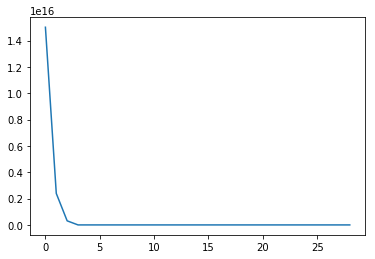

In [479]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_train_transformed = pca.fit_transform(X_train_limited)
#pca.fit(X_train_limited)
pca.explained_variance_ratio_
plt.plot(pca.explained_variance_)
plt.show()


In [480]:
num_comp = np.sum(np.cumsum(pca.explained_variance_ratio_) < .99)
print num_comp
X_limited_reduced = pca.transform(X_train_limited)[:, :num_comp]


2


In [481]:
comp0 = pd.Series(dict(zip(X_train_limited.columns, y_train)))
col_order = comp0.sort_values().index

In [476]:
print comp0[col_order].head(50)

addr_dif          1
numpunct          1
price_per_room    1
numfeatures       1
numcaps           1
weekday           1
month             1
richness          1
hr_min            1
numwords          1
hour              1
feat_2            1
second            1
desc_3            1
desc_2            1
desc_1            1
day               1
bedrooms          1
strlen            1
feat_3            1
price_per_bath    1
year              2
numphotos         2
minute            2
feat_1            2
bathrooms         2
price_per_bed     3
price             3
neighborhood      3
dtype: int64


# do we need to choose value at each step (neigh, baths, yrs) or the top n (neigh, price, ppbed)

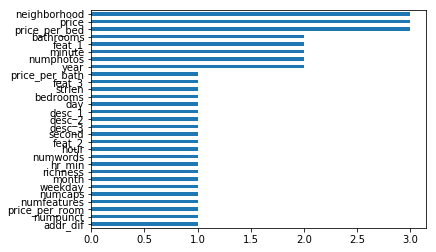

In [477]:
#plt.figure(figsize=(4, 24))
comp0[col_order].plot(kind='barh')
plt.show()
#why is year so high when they all have same one!? this seems wrong

In [498]:
def check_pca(name, X_train, y_train, X_dev, y_dev):
    #LR
    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    print('===============================')
    print(name)
    
    print('LR Training Accuracy: %.2f%% \t Test Accuracy: %.2f%%' % (
        lr.score(X_train, y_train)*100,                                                         
        lr.score(X_dev, y_dev)*100))
 
    #precision (% select relevent), recall (% relevant selected)
    print ('LR dev: \n{}'.format(classification_report(y_dev, lr.predict(X_dev))))
    print itemfreq(lr.predict(X_dev))

numeric_feature_list = ['feat_1','feat_2','feat_3', 'desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_dev_transformed = pca.transform(X_dev[numeric_feature_list])
check_pca('check pca',X_train_transformed, y_train, X_dev_transformed, y_dev)

check pca
LR Training Accuracy: 40.29% 	 Test Accuracy: 40.40%
LR dev: 
             precision    recall  f1-score   support

          1       0.82      0.36      0.50      6797
          2       0.25      0.57      0.35      2334
          3       0.13      0.30      0.18       740

avg / total       0.64      0.40      0.44      9871

[[   1 2972]
 [   2 5209]
 [   3 1690]]


In [506]:
X_test_transformed = pca.transform(X_test[numeric_feature_list])
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)
predictions_pca = lr.predict_proba(X_test_transformed)
print(lr.classes_)

final_table_pca = pd.DataFrame(data=predictions_pca, 
                               index=X_test.index)
print final_table_pca.head()
final_table_pca.columns = [['low', 'medium','high']]
print final_table_pca[['high','medium','low']].head()
final_table_pca.to_csv("pca_submission02.csv", index=True)

[1 2 3]
                   0         1         2
listing_id                              
7142618     0.309481  0.350133  0.340386
7210040     0.307605  0.349262  0.343132
7103890     0.322160  0.342677  0.335163
7143442     0.309545  0.345802  0.344653
6860601     0.340349  0.327676  0.331975
                high    medium       low
listing_id                              
7142618     0.340386  0.350133  0.309481
7210040     0.343132  0.349262  0.307605
7103890     0.335163  0.342677  0.322160
7143442     0.344653  0.345802  0.309545
6860601     0.331975  0.327676  0.340349


## less features

## Checking if columns are correctly mapped

In [489]:
X_train_desc = X_train[['desc_1', 'desc_2', 'desc_3']]
print X_train_desc.head()

my_desc_mnb2 = get_desc_mnb(X_train, y_train)
X_test_desc = X_test
X_test_desc = get_description_scores(X_test_desc,my_desc_mnb2)

X_test_desc_a = X_test_desc[['desc_3','desc_2', 'desc_1']]
print X_test_desc_a.head()

rfc_desc = RandomForestClassifier(n_estimators=20, n_jobs=-1) #-1 means use all available cores
rfc_desc.fit(X_train_desc, y_train)
print X_train_limited.shape
labels = rfc_desc.classes_

predictions_desc = rfc_desc.predict_proba(X_test_desc_a)
print predictions_desc.shape


              desc_1    desc_2    desc_3
listing_id                              
6879986     0.721063  0.199006  0.079931
7119254     0.779461  0.172159  0.048380
7089837     0.901391  0.093668  0.004942
6998694     0.696208  0.225298  0.078493
7151313     0.847709  0.138279  0.014012
              desc_3    desc_2    desc_1
listing_id                              
7142618     0.083044  0.232138  0.684818
7210040     0.096256  0.247925  0.655819
7103890     0.066380  0.221829  0.711791
7143442     0.060850  0.196435  0.742715
6860601     0.044001  0.207359  0.748640
(39481, 29)
(74659, 3)


In [433]:
#reorganize to high mid low
print predictions_desc
print rfc_desc.classes_

final_table_desc = pd.DataFrame(data=predictions_desc, index=X_test_desc_a.index)
print final_table_desc.head()
final_table_desc.columns = [['high', 'mid','low']]
print final_table_desc[['high','mid','low']].head()

#print final_table_desc[['high','middle','low']].head()
#final_table_desc.to_csv("sumbmission004.csv", index=True)

[[ 0.          0.25166667  0.74833333]
 [ 0.          0.1125      0.8875    ]
 [ 0.          0.55        0.45      ]
 ..., 
 [ 0.08333333  0.16666667  0.75      ]
 [ 0.          0.          1.        ]
 [ 0.          0.25        0.75      ]]
[1 2 3]
                   0         1         2
listing_id                              
7142618     0.000000  0.251667  0.748333
7210040     0.000000  0.112500  0.887500
7103890     0.000000  0.550000  0.450000
7143442     0.050000  0.050000  0.900000
6860601     0.141667  0.166667  0.691667
                high       mid       low
listing_id                              
7142618     0.000000  0.251667  0.748333
7210040     0.000000  0.112500  0.887500
7103890     0.000000  0.550000  0.450000
7143442     0.050000  0.050000  0.900000
6860601     0.141667  0.166667  0.691667
